In [1]:
import numpy as np
import matplotlib.pyplot as plt

### а) Показать, что, если алгоритм центрального пути сходится, то он сходится к решения задачи ЛП

<div style="float: left; width: 30%;">Прямая задача: <br>
max $c^Tx$ <br>
$Ax + x_s = b$ <br>
$x, x_s \geq 0$
</div><div style="float: left; width: 70%;">
Двойственная задача: <br>
min $b^Ty$ <br>
$A^Ty - y_s = c$ <br>
$y, y_s \geq 0$
</div><div class="clear">
<t>На каждом шаге ищем $x, x_s, y, y_s$ такие, что F($x, x_s, y, y_s, \mu$) = $\begin{pmatrix} Ax + x_s - b \\  A^Ty - y_s - c\\ XY_s\textbf1 - \mu\textbf1 \\ X_sY\textbf1 - \mu\textbf1 \end{pmatrix} = \vec0$ 
<br> Уравнения из первых двух строчек системы гарантируют нам, что точки $x, x_s, y, y_s$ являются допустимыми для соответствующих задач ЛП
<br> Из последних двух уравнений получаем, что в пределе ($\mu = 0$) $x^iy_s^i = 0, x_s^jy^j = 0$  $\forall i \in\overline{1,n}, j \in\overline{1,m}  $, из чего при помощи теоремы о комплиментарности делаем вывод, что $x, x_s, y, y_s$ - решения соответствующих задач ЛП

### b) Реализовать алгоритм демпфированного метода Ньютона 
для задачи <br>solve $F(x, 𝑥𝑠, 𝑦, 𝑦𝑠, 𝜇) = \vec0$ <br>$x,x_s,y,y_s>0$

Функция F векторная, метод Ньютона определен для скалярной. Будем решать задачу G($x, x_s, y, y_s, \mu$) = $<F,F>^2$, ее решение, очевидно, является решением исходной. <br>


In [2]:
def G_value(x, x_s, y, y_s, mu):
    r1, r2 = np.dot(A, x) + x_s - b, np.dot(A.transpose(), y) - y_s - c
    v1, v2 = np.array([x[i]*y_s[i] - mu for i in range(len(x))]), np.array([x_s[j]*y[j] - mu for j in range(len(y))])
    return np.dot(r1, r1) + np.dot(r2, r2) + np.dot(v1, v1) + np.dot(v2, v2)

gradG может быть посчитан аналитически <br>
$\frac{\partial G}{\partial x^i} = 2(Ax + x_s -b)A^T[i] + 2(x^iy_s^i - \mu)y_s^i$,   $i \in \overline{1,n}$ <br>
$\frac{\partial G}{\partial x_s^j} = 2(Ax + x_s -b)_j + 2(x_s^jy^j - \mu)y^j$,   $j \in \overline{1,m}$ <br>
$\frac{\partial G}{\partial y^j} = 2(A^Ty - y_s - c)A[j] + 2(x_s^jy^j - \mu)x_s^j$,   $j \in \overline{1,m}$ <br>
$\frac{\partial G}{\partial y_s^i} = -2(A^Ty - y_s - c)_i + 2(x^iy_s^i - \mu)x^i$,   $i \in\overline{1,n}$ <br>
Здесь A[i] - i-ая строка матрицы

In [3]:
def grad_G(x, x_s, y, y_s, mu):
    r1 = np.dot(A, x) + x_s - b
    r2 = np.dot(A.transpose(), y) - y_s - c
    grad_x, grad_x_s, grad_y, grad_y_s = np.zeros(len(x)), np.zeros(len(x_s)), np.zeros(len(y)), np.zeros(len(y_s))
    for i in range(len(x)):
        grad_x[i] = 2*np.dot(r1, A.transpose()[i]) + 2*(x[i]*y_s[i] - mu)*y_s[i]
        grad_y_s[i] = -2 * r2[i] + 2 * (x[i] * y_s[i] - mu) * x[i]
    for j in range(len(y)):
        grad_y[j] = 2*np.dot(r2, A[j]) + 2*(x_s[j]*y[j] - mu)*x_s[j]
        grad_x_s[j] = 2 * r1[j] + 2 * (x_s[j] * y[j] - mu) * y[j]
    return grad_x, grad_x_s, grad_y, grad_y_s

В следующей функции определяем, куда нам шагнуть из текущего положения <br>
$x_{n+1} = x_n - \alpha \frac {gradG(x_n)}{|gradG(x_n)|}$ <br>
$\alpha$ выбираем так, чтобы координаты $x_{n+1}$ были неотрицательными <br>
$\alpha_{max} = \frac {G(x_n)}{|gradG(x_n)|}$ <br>
$\alpha = min(\alpha_{max}, min(\frac {x_i}{gradG[i]}, \alpha_{max}))$  $\forall i$ т.ч $gradG[i] > 0$



In [4]:
def calc_next_point(x, x_s, y, y_s, mu):
    grad_x, grad_x_s, grad_y, grad_y_s = grad_G(x, x_s, y, y_s, mu)
    X = np.hstack((x, x_s, y, y_s))
    gradG_X = np.hstack((grad_x, grad_x_s, grad_y, grad_y_s))
    G_X = G_value(x, x_s, y, y_s, mu)
    for i in range(len(X)):
        if gradG_X[i] > 0 and X[i] == 0:
            gradG_X[i] = 0
    alpha = G_X/np.linalg.norm(gradG_X)
    for i in range(len(X)):
        if gradG_X[i] > 0 and X[i] == 0:
            gradG_X[i] = 0
        if gradG_X[i] > 0:
            alpha = min(alpha, X[i]/(gradG_X[i]/np.linalg.norm(gradG_X)))
    X_next = X - G_X*gradG_X/np.linalg.norm(gradG_X)**2
    for i in range(len(X_next)):
        if X_next[i] < 0:
            X_next[i] = 0
    return X_next[:len(x)], X_next[len(x):len(x) + len(x_s)], X_next[len(x) + len(x_s):len(x) + len(x_s) + len(y)], X_next[len(x) + len(x_s) + len(y):len(x) + len(x_s) + len(y) + len(y_s)]

Наконец, находим решение задачи G = 0

In [5]:
def solve_G(mu):
    x, y_s, x_s, y = 2*np.ones(n), np.ones(n), np.ones(m), np.ones(m)
    while True:
        x_next, x_s_next, y_next, y_s_next = calc_next_point(x, x_s, y, y_s, mu)
        if np.linalg.norm(x - x_next) <= e1 and np.linalg.norm(x_s - x_s_next) <= e2 and np.linalg.norm(y - y_next) <= e3 and np.linalg.norm(y_s - y_s_next) <= e4:
                break
        x, x_s, y, y_s = x_next, x_s_next, y_next, y_s_next
    return x, x_s, y, y_s

### c) Показать экспериментально, что с помощью построенного алгоритма можно решить задачи ЛП
Решаем заданную задачу ЛП <br>
Входные данные:
<br>
e1, e2, e3, e4 - погрешности для $x, x_s, y, y_s$ соответственно <br>
k_max - максимальное число итераций метода центрального пути

In [6]:
A = np.array([[1, 2], [2, 1]])
b = np.array([2, 2])
c = np.array([3, 4])
m, n = A.shape[0], A.shape[1]
acc = 10**(-6)
e1, e2, e3, e4 = acc, acc, acc, acc
k_max = 300

In [7]:
def central_path():
    path_x, path_y, path_mu = list(), list(), list()
    x, y_s, x_s, y = 2*np.ones(n), np.ones(n), np.ones(m), np.ones(m)
    mu = 15.0
    for i in range(k_max):
        x_next, x_s_next, y_next, y_s_next = solve_G(mu)
        if np.linalg.norm(x - x_next) <= e1 and np.linalg.norm(x_s - x_s_next) <= e2 and np.linalg.norm(y - y_next) <= e3 and np.linalg.norm(y_s - y_s_next) <= e4:
            break;
        path_x.append(x[0])
        path_y.append(x[1])
        path_mu.append(mu)
        x, x_s, y, y_s = x_next, x_s_next, y_next, y_s_next
        mu /= 2
    return x, path_x, path_y, path_mu

вывод результатов на плоскости

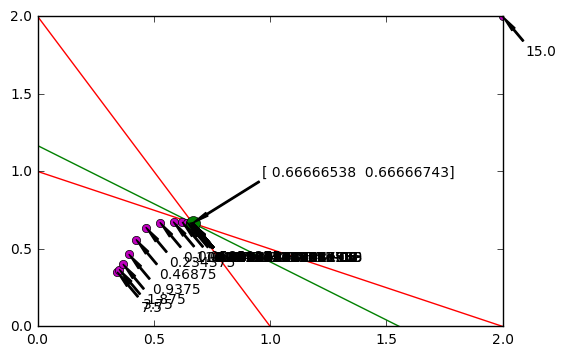

In [8]:
def draw_line(a, b, color):
    #plots a line with a[0]x + a[1]y = b
    points_x = list()
    points_y = list()
    if a[1] == 0:
        points_x = [b/a[0], b/a[0]]
        points_y = [0, 5]
    elif a[0] == 0:
        points_x = [0, 5]
        points_y = [b/a[1], b/a[1]]
    else:
        if(a[0] < 0):
            a = -a
        if (a[1] > 0):
            points_x = [0, b/a[0]]
            points_y = [b/a[1], 0]
        else:
            points_x = [b/a[0], 5]
            points_y = [0, (b - 5*a[0])/a[1]]
    plt.plot(points_x, points_y, color)
    
plt.clf()
for i in range(A.shape[0]):
    draw_line(A[i], b[i], 'r')
x, path_x, path_y, path_mu = central_path()
value = np.dot(x, c)
draw_line(c, value, 'g')
for i in range(len(path_x)):
    plt.plot(path_x[i], path_y[i], 'mo')
    if(path_mu >= 0.15):
        plt.annotate(str(path_mu[i]), xy=(path_x[i], path_y[i]), xytext=(path_x[i] + 0.1, path_y[i] - 0.25), arrowprops=dict(headwidth = 3, facecolor='black', shrink=2, width = 1))
plt.plot(x[0], x[1], 'go', markersize = 10)
plt.annotate(str(x), xy=(x[0], x[1]), xytext=(x[0] + 0.3, x[1] + 0.3), arrowprops=dict(headwidth = 3, facecolor='black', shrink=2, width = 1))

plt.show()

### d) Сформулировать условие выхода, которое позволяет детектировать неограниченность задачи.


Исходная задача неограничена тогда и только тогда, когда войственная ей не совместна, т е у $A^Ty - y_s = c$,
$y, y_s \geq 0$ нет допустимых точек